In [2]:
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import time
import copy


# Models


## Attention Layer


In [4]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted

## RNN


In [5]:
class NetRNN(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True)
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        self.h0 = torch.Tensor(numpy.zeros((1, x.shape[0], self.hidden_dim)))
        out, self.h0 = self.rnnLayer(x, self.h0)
        out = torch.tanh(out)
        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.Tensor(numpy.zeros((1, 1, self.hidden_dim)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.rnnLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())
            out = torch.tanh(out)
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)


## RNN With Attention then Expansion


In [6]:
class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')
        
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)
        print(attn_out.shape)
        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        print(expanded_attn_out.shape)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # RNN processing
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(expanded_attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # RNN processing
                out, h0 = self.rnnLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


In [ ]:
model = NetRNNWithAttention()
print(model)
print(model(torch.Tensor(np.random.random((1,30,3)))))

## RNN Expansion first then Attention


In [ ]:
class NetRNNWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # RNN layer
        self.rnnLayer = nn.RNN(self.hidden_dim, self.hidden_dim, batch_first=True, nonlinearity='tanh')

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # RNN processing
        h0 = torch.zeros(1, attn_out.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # RNN processing
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetRNNWithAttention(hidden_dim=12)


## LSTM


In [7]:
class NetLSTM(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), 1, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # Initialize hidden and cell states
        self.h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
                   torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))

        # LSTM processing
        out, self.h0 = self.lstmLayer(x, self.h0)
        out = torch.tanh(out)  # Apply tanh to the LSTM output if needed

        # Concatenate hidden and cell states
        hh = numpy.concatenate((self.h0[0].detach().numpy(), self.h0[1].detach().numpy()), 2)
        self.hidden.append(hh)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                out, h0 = self.lstmLayer(step_input, h0)
                hh = numpy.concatenate((h0[0].detach().numpy().flatten(), h0[1].detach().numpy().flatten()))
                H.append(hh.flatten())

            out = torch.tanh(out)  # Apply tanh to the LSTM output if needed
            out = torch.tanh(self.outputLayer(out[:, -1, :]))
            for i in range(x.shape[1]):
                O.append(out.detach().numpy().flatten())
        return numpy.array(O), numpy.array(H)
    
model = NetLSTM(hidden_dim=12)


## LSTM with Attention then Expansion


In [8]:
class NetLSTMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer to match CustomRNN
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim/2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim/2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim/2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim/2)))
        lstm_out, _ = self.lstmLayer(expanded_attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim/2)),
                  torch.zeros(1, 1, int(self.hidden_dim/2)))
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # LSTM processing
                out, h0 = self.lstmLayer(expanded_attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetLSTMWithAttention(hidden_dim=12)


## LSTM Expansion first then Attention


In [9]:
class NetLSTMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetLSTMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # LSTM layer
        self.lstmLayer = nn.LSTM(self.hidden_dim, int(self.hidden_dim / 2), batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(int(self.hidden_dim / 2), 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # LSTM processing
        h0 = (torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)),
              torch.zeros(1, x.shape[0], int(self.hidden_dim / 2)))
        lstm_out, _ = self.lstmLayer(attn_out, h0)
        lstm_out = torch.tanh(lstm_out)

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(lstm_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = (torch.zeros(1, 1, int(self.hidden_dim / 2)),
                  torch.zeros(1, 1, int(self.hidden_dim / 2)))
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # LSTM processing
                out, h0 = self.lstmLayer(attn_out, h0)
                H.append(torch.cat((h0[0].detach(), h0[1].detach()), 2).numpy().flatten())

                out = torch.tanh(out)
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetLSTMWithAttention(hidden_dim=12)


## GRU


In [10]:
class NetGRU(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        x = self.expand_layer(x)
        x = torch.tanh(x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(x, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer to each step
                step_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                step_input = torch.tanh(step_input)

                # GRU processing
                out, h0 = self.gruLayer(step_input, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)
    
model = NetGRU(hidden_dim=12)


## GRU with Attention then Expansion


In [11]:
class NetGRUMWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Attention layer
        self.attention = SelfAttention(inp)  # Assuming SelfAttention is defined elsewhere

        # Expansion layer
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply attention
        attn_out = self.attention(x)

        # Apply the expansion layer with tanh activation
        expanded_attn_out = self.expand_layer(attn_out)
        expanded_attn_out = torch.tanh(expanded_attn_out)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(expanded_attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Apply the expansion layer with tanh activation
                expanded_attn_out = self.expand_layer(attn_out)
                expanded_attn_out = torch.tanh(expanded_attn_out)

                # GRU processing
                out, h0 = self.gruLayer(expanded_attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


## GRU Expansion first then Attention


In [ ]:
class NetGRUMWithAttentionExpFirst(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetGRUMWithAttentionExpFirst, self).__init__()
        self.hidden_dim = hidden_dim
        self.inp = inp

        # Expansion layer first
        self.expand_layer = nn.Linear(in_features=self.inp, out_features=self.hidden_dim)

        # Attention layer applied after expansion
        self.attention = SelfAttention(self.hidden_dim)  # Assuming SelfAttention is defined elsewhere

        # GRU layer
        self.gruLayer = nn.GRU(self.hidden_dim, self.hidden_dim, batch_first=True)

        # Output layer
        self.outputLayer = nn.Linear(self.hidden_dim, 3)

        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Apply the expansion layer with tanh activation
        expanded_x = self.expand_layer(x)
        expanded_x = torch.tanh(expanded_x)

        # Apply attention
        attn_out = self.attention(expanded_x)

        # GRU processing
        self.h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        out, self.h0 = self.gruLayer(attn_out, self.h0)
        out = torch.tanh(out)

        self.hidden.append(copy.deepcopy(self.h0.detach().numpy()))

        # Final output layer with tanh activation
        out = torch.tanh(self.outputLayer(out[:, -1, :]))
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Apply the expansion layer with tanh activation
                expanded_input = self.expand_layer(x[l][i].reshape((1, 1, self.inp)))
                expanded_input = torch.tanh(expanded_input)

                # Applying attention to each timestep
                attn_out = self.attention(expanded_input)

                # GRU processing
                out, h0 = self.gruLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)  # Apply tanh to the GRU output if needed
                out = torch.tanh(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)

model = NetGRUMWithAttention(hidden_dim=12)


# Data Generation


In [9]:
def generateTrainData(num_samples, min_max):
    s = []  # Sequences
    t = []  # Labels
    params = {
    "min_length": min_max[0],
    "max_length": min_max[1],
    "fill": 0,
    "value_1": -1,
    "value_2": 1,
}
    for _ in range(num_samples):
        common_length = np.random.randint(params["min_length"], params["max_length"] + 1)

        array_A = np.full(common_length, params["fill"])
        array_B = np.full(common_length, params["fill"])
        array_C = np.full(common_length, params["fill"])

        # Exclude the last two indices
        possible_indices = np.arange(common_length - 2)

        index_A = np.random.choice(possible_indices)
        value_A = np.random.choice([params["value_1"], params["value_2"]])
        array_A[index_A] = value_A

        # Update possible indices for array B to also exclude index_A
        possible_indices_B = np.delete(possible_indices, np.where(possible_indices == index_A))
        index_B = np.random.choice(possible_indices_B)
        value_B = np.random.choice([params["value_1"], params["value_2"]])
        array_B[index_B] = value_B

        value_C = np.random.choice([params["value_1"], params["value_2"]])
        array_C[-1] = value_C
        array_C[-2] = value_C

        mapped_value_A = 1 if value_A == params["value_2"] else 0
        mapped_value_B = 1 if value_B == params["value_2"] else 0
        #value_1 = -1
        #value_2 = 1
        if value_C == params["value_1"]: # XOR
            result = int(mapped_value_A != mapped_value_B) 
        else : # XNOR
            result =  int(mapped_value_A == mapped_value_B)

        # Mapping back to original value_1 and value_2 for the label
        label_value_A = params["value_2"] if mapped_value_A == 1 else params["value_1"]
        label_value_B = params["value_2"] if mapped_value_B == 1 else params["value_1"]
        results_XORNOR= params["value_2"] if result == 1 else params["value_1"]

        #label_arr = [mapped_value_A, mapped_value_B, result]  # Label array with value_A, value_B, and result
        label_arr = [label_value_A, label_value_B, results_XORNOR]  # Label array with value_A, value_B, and result

        combined_array = np.vstack([array_A, array_B, array_C]).T
        s.append(combined_array)
        t.append(label_arr)

    return s, np.array(t)


In [ ]:
num_seq = 1
# Example dictionary with parameters
sequences, labels = generateTrainData(num_seq, [5,5])
print(sequences)
print(labels)

In [ ]:

sequences, labels = generateTrainData(1, [10,10])
model = NetRNN()
output=model(torch.Tensor(sequences))
print(torch.Tensor(sequences))
print(output.shape)
print(model)

In [ ]:
sequences, labels = generateTrainData(5, [10,15])

def plot_sequences(sequences, labels):
    num_samples = len(sequences)  # Number of samples to display

    # Plotting
    plt.figure(figsize=(3 * num_samples, 15))

    for i, (seq, label) in enumerate(zip(sequences, labels)):
        reshaped_sequence = seq  # Use the sequence as it is

        ax = plt.subplot(1, num_samples, i + 1)
        img = ax.imshow(
            reshaped_sequence, cmap="gray", vmin=-1.0, vmax=1.0
        )  # Adjusted vmin and vmax
        operation_title = "XOR" if seq[-1][2] == -1 else "XNOR"
        ax.set_title(f"Operation: {operation_title}, {label}")

        ax.set_xlabel("Arrays (A, B, C)")
        ax.set_ylabel("Time Points")
        ax.set_xticks(range(3))
        ax.set_xticklabels(["A", "B", "C"])
        ax.set_yticks(range(reshaped_sequence.shape[0]))
        ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

    # Adjusted positioning of colorbar
    cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(img, cax=cbar_ax)
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(["-1", "0", "1"])

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()


# Example usage
# Assuming sequences and labels are already generated using generateTrainData
plot_sequences(sequences, labels)

In [ ]:
parameters_list = []

# min_lengths = [5, 10, 10, 20, 20, 40, 40, 70,100]
# max_lengths = [5, 10, 15, 20, 25, 40, 45,75,140]
min_lengths = [10]
max_lengths = [10]

# Training


In [ ]:
collectorA = dict()
num_samples = 100
for rep in range(3):  # Number of repetitions
    for min_len, max_len in zip(min_lengths, max_lengths):
        # Select the model based on 'kind'
        for kind in ["RNN", "RNNA", "RNNE","LSTM", "LSTMA","LSTME", "GRU", "GRUA","GRUE"]:
        # Select the model based on 'kind'
            if kind == "RNN":
                model = NetRNN(hidden_dim=12, inp=3)
            elif kind == "RNNA":
                model = NetRNNWithAttention(hidden_dim=12, inp=3)
            elif kind == "RNNE":
                model = NetRNNWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "LSTM":
                model = NetLSTM(hidden_dim=12, inp=3)
            elif kind == "LSTMA":
                model = NetLSTMWithAttention(hidden_dim=12, inp=3)
            elif kind == "LSTME":
                model = NetLSTMWithAttentionExpFirst(hidden_dim=12, inp=3)
            elif kind == "GRU":
                model = NetGRU(hidden_dim=12, inp=3)
            elif kind == "GRUA":
                model = NetGRUMWithAttention(hidden_dim=12, inp=3)
            elif kind == "GRUE":
                model = NetGRUMWithAttentionExpFirst(hidden_dim=12, inp=3)

            optimizer = optim.Adam(model.parameters())
            criterion = nn.MSELoss()
            acc = 0.0
            W = []
            AC = []
            start_time = time.time()  # Start time of the epoch

            while True:
                sequences, targets = generateTrainData(num_samples, [min_len,max_len])
                total_loss = 0
                total_acc = 0
                count = 0

                for seq, target in zip(sequences, targets):
                    optimizer.zero_grad()
                    seq_tensor = torch.Tensor([seq])  # Add an extra dimension for batch
                    target_tensor = torch.Tensor([target])

                    output = model(seq_tensor)
                    loss = criterion(output, target_tensor)
                    total_loss += loss.item()

                    loss.backward()
                    optimizer.step()

                    # Calculate accuracy
                    A = 1.0 * (target_tensor.detach() > 0.0)
                    B = 1.0 * (output.detach() > 0.0)
                    acc = (1.0 * (A.flatten() == B.flatten())).mean()
                    total_acc += acc
                    count += 1

                avg_loss = total_loss / count
                avg_acc = total_acc / count
                W.append(avg_loss)
                AC.append(avg_acc)
                print(f"{kind}, rep: {rep}, epoch: {len(AC)}, acc: {avg_acc}, Loss {avg_loss}")

                # Check for stopping condition
                if avg_acc >= 0.97 or len(W)>2000:
                    break

                end_time = time.time()  # End time of the epoch
                epoch_duration = end_time - start_time  # Calculate duration
                collectorA[f"{kind}_rep_{rep}_min_{min_len} max_{max_len}"] = AC
                torch.save(model, f'model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model')
                print(f"{kind:<20} Rep: {rep:<3} Epoch: {len(A):<5} Acc: {avg_acc:.4f} " f"_min_{min_len}_max_{max_len} Time: {epoch_duration:.2f} sec")
                df=pd.DataFrame()
                df["accuracy"]=AC
                df["loss"]=W
                df.to_csv(f'score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv')

In [ ]:
print(collectorA.keys())

# Accuracy plots


In [ ]:
def tensor_str_to_float(tensor_str):
    # Convert a string like 'tensor(0.4533)' to a float
    return float(tensor_str.strip('tensor()'))

def pad_data(data, target_length):
    # Truncate or extend the data to the target length
    if len(data) > target_length:
        return data[:target_length]
    else:
        pad_value = data[-1] if data else 0  # Use last value or 0 if data is empty
        x = data + [pad_value] * (target_length - len(data))
        return x[:target_length]

In [ ]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Plotting for each kind
for kind in kinds:
    plt.figure(figsize=(10, 20))  # Adjust the figure size for 2x5 layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid
        rep_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'

            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                rep_data.append(padded_data)
                ax.plot(padded_data, label=f"Rep {rep+1}", alpha=0.5,linewidth=0.8, color='gray')
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if not rep_data:
            continue

        avg_data = np.mean(np.array(rep_data), axis=0)
        ax.plot(avg_data, label="Average", linewidth=1, color='black')

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        #if i == 0:  # Add legend only to the first subplot
        #    ax.legend()
        ax.set_ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


    


In [ ]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Adjusting the plot to grayscale and using fill_between for replicates
def plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch):
    plt.figure(figsize=(10, 10))  # Adjust the figure size for layout

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        rep_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                rep_data.append(padded_data)
            except FileNotFoundError:
                continue

        if not rep_data:
            continue

        avg_data = np.mean(rep_data, axis=0)
        std_dev = np.std(rep_data, axis=0)

        # Plot replicates as fill_between
        ax.fill_between(range(target_epoch), avg_data - std_dev, avg_data + std_dev, color='gray', alpha=0.3)
        
        # Plot average as a black line
        ax.plot(avg_data, label="Average", linewidth=2, color='black')

        ax.set_title(f"{kind} (Min: {min_len} - Max: {max_len})")
        ax.set_ylabel("Accuracy")
        ax.set_xlabel("Epoch")

    plt.tight_layout()
    plt.show()

# Plotting for each kind
for kind in kinds:
    plot_with_grayscale_fill_between(kind, min_lengths, max_lengths, num_reps, target_epoch)


In [ ]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50, 10, 20, 30, 40, 50]
max_lengths = [10, 20, 30, 40, 50, 15, 25, 35, 45, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the plots
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # Create subplots in a 3x2 grid

    for j, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        combination_avg_data = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                combination_avg_data.append(padded_data)
            except FileNotFoundError:
                continue

        if combination_avg_data:
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            line_style = '--' if min_len == max_len else '-'
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}", linewidth=0.8, linestyle=line_style)

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    if i == 0:  # Add legend only to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50]  # Adjusted values
max_lengths = [15, 25, 35, 45, 55]  # Adjusted values
num_reps = 31  # Number of repetitions
target_epoch = 2000  # Target number of epochs

# Create a single figure for the 3x3 grid
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3,2, i + 1)  # Create subplots in a 3x3 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            # Calculate the average for this min/max length combination
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}")

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()




In [ ]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 20, 30, 40, 50, 10, 20, 30, 40, 50]  # Adjusted values
max_lengths = [10, 20, 30, 40, 50, 15, 25, 35, 45, 55]  # Adjusted values
num_reps = 31  # Number of repetitions
target_epoch = 2000  # Target number of epochs

# Create a single figure for the 3x3 grid
plt.figure(figsize=(15, 15))

for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # Create subplots in a 3x3 grid

    for min_len, max_len in zip(min_lengths, max_lengths):
        combination_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                combination_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if combination_avg_data:
            avg_data = np.mean(np.array(combination_avg_data), axis=0)
            line_style = '--' if min_len == max_len else '-'
            ax.plot(avg_data, label=f"Min {min_len}, Max {max_len}", linewidth=0.8, linestyle=line_style)

    ax.set_title(f"{kind}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()




In [ ]:
kinds = ["RNN", "LSTM","GRU"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
kinds = ["RNNA", "LSTMA",  "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
kinds = ["RNNE", "LSTME", "GRUE"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}")

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
#kinds = ["RNN", "RNNA", "RNNE", "LSTM", "LSTMA", "LSTME", "GRU", "GRUA", "GRUE"]
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Create a single figure for the 2x5 grid
plt.figure(figsize=(10, 20))

for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

    for kind in kinds:
        model_avg_data = []

        for rep in range(num_reps):
            #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                model_avg_data.append(padded_data)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if model_avg_data:
            # Calculate the average for this model kind
            avg_data = np.mean(np.array(model_avg_data), axis=0)
            ax.plot(avg_data, label=f"{kind}", linewidth= 0.8)

    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
#model_groups = {
#    "RNN": ["RNN", "RNNA", "RNNE"],
#    "LSTM": ["LSTM", "LSTMA", "LSTME"],
#    "GRU": ["GRU", "GRUA", "GRUE"]
#}

model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31
target_epoch = 2000

# Plotting for each model group
for group_name, kinds in model_groups.items():
    plt.figure(figsize=(10, 20))  # Create a single figure for the 2x5 grid

    for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
        ax = plt.subplot(5, 2, i + 1)  # Create subplots in a 2x5 grid

        for kind in kinds:
            kind_avg_data = []

            for rep in range(num_reps):
                #filename = f'./data/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    padded_data = pad_data(data['accuracy'].tolist(), target_epoch)
                    kind_avg_data.append(padded_data)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if kind_avg_data:
                # Calculate the average for this kind and length combination
                avg_data = np.mean(np.array(kind_avg_data), axis=0)
                ax.plot(avg_data, label=f"{kind}")

        ax.set_title(f"Min {min_len}, Max {max_len}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Accuracy")
        ax.legend()

    plt.suptitle(f"Average Accuracy for {group_name} Models")
    plt.tight_layout()
    plt.show()


In [ ]:
# Function to find the first epoch where accuracy reaches 80%
def find_epoch_at_80_percent(accuracy_list):  
    for i, acc in enumerate(accuracy_list):
        if acc >= 0.80:
            return i
    return None

In [ ]:
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10 ,20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15 ,20, 25, 30, 35, 40, 45, 50, 55]

# Placeholder for the results
results = []
labels = []

for kind in kinds:
    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results.append((kind, min_len, max_len, avg_epoch))
            labels.append(f"Min {min_len}, Max {max_len}")


# Preparing data for bar plot
df = pd.DataFrame(results, columns=["Kind", "Min_Length", "Max_Length", "Avg_Epoch"])

# Plotting
plt.figure(figsize=(15, 10))

for i, kind in enumerate(kinds):
    subset = df[df['Kind'] == kind]
    x = range(len(subset))
    plt.bar(x, subset['Avg_Epoch'], tick_label=labels[len(x)*i:len(x)*(i+1)],label=f"{kind}")

plt.xlabel("Combination Index")
plt.ylabel("Average Epoch at 80% Accuracy")
plt.title("Average Epoch at 80% Accuracy for Each Configuration")
plt.legend()
plt.show()

In [ ]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [10 ,20, 30, 40, 50]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = []

# Gathering data for the bar plot
for kind in kinds:
    kind_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            kind_results.append(avg_epoch)
        else:
            kind_results.append(None)

    results.append(kind_results)

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model kind
for i, kind in enumerate(kinds):
    ax = plt.subplot(3, 2, i + 1)  # 3x2 grid for 6 kinds
    bar_positions = np.arange(len(min_lengths))  # One bar for each min/max length combination

    # Plot the bars
    ax.bar(bar_positions, results[i], width=0.4)

    # Set up the plot
    ax.set_title(kind)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
# Constants
kinds = ["RNN", "RNNA", "LSTM", "LSTMA", "GRU", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Constants
kinds = ["RNN", "LSTM", "GRU", ]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Constants
kinds = ["RNNA", "LSTMA", "GRUA"]
min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {kind: [] for kind in kinds}

# Gathering data for the bar plot
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        epochs_to_80_percent = []

        for rep in range(num_reps):
            filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
            try:
                data = pd.read_csv(filename)
                data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                if epoch is not None:
                    epochs_to_80_percent.append(epoch)
            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

        if epochs_to_80_percent:
            avg_epoch = np.mean(epochs_to_80_percent)
            results[kind].append(avg_epoch)
        else:
            results[kind].append(None)

# Creating the bar plot
plt.figure(figsize=(10, 20))  # Adjust the figure size as needed

# Create a subplot for each min/max length configuration
for i, (min_len, max_len) in enumerate(zip(min_lengths, max_lengths)):
    ax = plt.subplot(5, 2, i + 1)  # 5x2 grid for 10 configurations
    bar_positions = np.arange(len(kinds))  # One bar for each model kind

    # Plot the bars
    for j, kind in enumerate(kinds):
        ax.bar(bar_positions[j], results[kind][i], width=0.4, label=kind)

    # Set up the plot
    ax.set_title(f"Min {min_len}, Max {max_len}")
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(kinds, rotation=45)
    ax.set_xlabel("Model Type")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [10 ,20, 30, 40, 50]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10 ,20, 30, 40, 50]
max_lengths = [15 ,25, 35, 45, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Model groups
model_groups = {
    "RNN": ["RNN", "RNNA"],
    "LSTM": ["LSTM", "LSTMA"],
    "GRU": ["GRU", "GRUA"]
}

min_lengths = [10, 10, 20, 20, 30, 30, 40, 40, 50, 50]
max_lengths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
num_reps = 31

# Placeholder for the results
results = {group: [] for group in model_groups}

# Gathering data for the bar plot
for group_name, kinds in model_groups.items():
    group_results = []

    for min_len, max_len in zip(min_lengths, max_lengths):
        kind_avg_epochs = []

        for kind in kinds:
            epochs_to_80_percent = []

            for rep in range(num_reps):
                filename = f'./dataScore/score_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.csv'
                try:
                    data = pd.read_csv(filename)
                    data['accuracy'] = data['accuracy'].apply(tensor_str_to_float)
                    epoch = find_epoch_at_80_percent(data['accuracy'].tolist())
                    if epoch is not None:
                        epochs_to_80_percent.append(epoch)
                except FileNotFoundError:
                    print(f"File not found: {filename}")
                    continue

            if epochs_to_80_percent:
                avg_epoch = np.mean(epochs_to_80_percent)
                kind_avg_epochs.append(avg_epoch)
            else:
                kind_avg_epochs.append(None)

        group_results.append(kind_avg_epochs)
    results[group_name] = group_results

# Creating the bar plot
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Create a subplot for each model group
for i, (group_name, group_kinds) in enumerate(model_groups.items()):
    ax = plt.subplot(len(model_groups), 1, i + 1)  # One row for each group
    bar_positions = np.arange(len(min_lengths))  # One set of bars for each min/max length combination

    # Plot the bars for each kind in the group
    bar_width = 0.15
    for j, kind in enumerate(group_kinds):
        kind_results = [result[j] for result in results[group_name]]  # Get results for this kind
        ax.bar(bar_positions + j * bar_width, kind_results, width=bar_width, label=kind)

    # Set up the plot
    ax.set_title(f"{group_name} Group")
    ax.set_xticks(bar_positions + bar_width * (len(group_kinds) - 1) / 2)
    ax.set_xticklabels([f"({min_len},{max_len})" for min_len, max_len in zip(min_lengths, max_lengths)], rotation=45)
    ax.set_xlabel("Min/Max Length")
    ax.set_ylabel("Average Epoch at 80% Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()


# Representation plots


In [10]:
# This function calculates the entropy of a dataset D using the Shannon entropy formula. Entropy is a measure of the unpredictability or randomness of the data.
def symbolEntropy(D, base=2):
    value, counts = numpy.unique(D, return_counts=True)  # Find unique values and their frequency in D
    return entropy(counts, base=base)  # Calculate and return the Shannon entropy

# This function seems to compute a complex metric, possibly related to information theory, involving inputs I, hidden states H, and outputs O.
def computeTransmissionHfast(I,H,O,maskC,maskNC,iMult=2,oMult=2):
    # Create various combinations of Inputs (I), Hidden states (H), and Outputs (O) for analysis
    # B, IB, AB, BO, IAB, IBO, ABO, IABO are different combinations of I, H, and O
    # Calculate entropy for each combination using symbolEntropy
    # Return a specific information metric combining these entropies


    #print("I H O",I.shape,H.shape,O.shape)
    B=numpy.bitwise_and(H,maskNC)
    IB=(B*iMult)+I
    AB=H#numpy.bitwise_and(H,maskC+maskNC)
    BO=(B*oMult)+O
    IAB=(AB*iMult)+I
    IBO=(B*(iMult*oMult))+(I*oMult)+O
    ABO=(AB*oMult)+O
    IABO=(AB*(iMult*oMult))+(I*oMult)+O
    hB=symbolEntropy(B, base=2)
    hIB=symbolEntropy(IB, base=2)
    hAB=symbolEntropy(AB, base=2)
    hBO=symbolEntropy(BO, base=2)
    hIAB=symbolEntropy(IAB, base=2)
    hIBO=symbolEntropy(IBO, base=2)
    hABO=symbolEntropy(ABO, base=2)
    hIABO=symbolEntropy(IABO, base=2)
    #-H(B)+H(IB)+H(AB)+H(BO)-H(IAB)-H(IBO)-H(ABO)+H(IABO)
    #print(hB,hIB,hAB,hBO,hIAB,hIBO,hABO,hIABO)
    return-hB+hIB+hAB+hBO-hIAB-hIBO-hABO+hIABO

# This function seems to analyze how information is processed or transmitted through a network, focusing on individual components (nodes) of the hidden states H.
def singleShrinkingDecompositionInformation(I,H,O,width,iMult=2,oMult=2):
    nodes = list(range(width))  # Initialize a list of node indices
    cols = []  # To store subsets of nodes
    colh = []  # To store corresponding information values
    # Iteratively remove a node, compute information value, and record subsets and values
    while len(nodes)>0:
        infos=[]
        for node in nodes:
            subset=copy.deepcopy(nodes)
            subset.remove(node)
            maskA=0
            for s in subset:
                maskA+=1*(2**s)
            maskA=int(maskA)
            maskB=numpy.bitwise_and(numpy.bitwise_not(maskA),((2**width)-1))
            h=computeTransmissionHfast(I,H,O,maskA,maskB,iMult=iMult,oMult=oMult)
            infos.append(h)
        nodeToDrop=nodes[infos.index(max(infos))]
        nodes.remove(nodeToDrop)
        cols.append(copy.deepcopy(nodes))
        colh.append(max(infos))
    return cols,colh


# This function processes the output of a model given a dataset. It appears to involve some form of clustering (using KMeans) and then re-encoding the hidden states H.
def getOutTaH(model,dataSet):
    O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model
    # Transform H using clustering and re-encoding

    #print(H.shape,H.min(),H.max())
    #figure()
    #hist(H.flatten())

    H = H.transpose()  # Transpose H for processing
    O = O.transpose()  # Transpose O for processing
    B = numpy.zeros(H.shape)  # Initialize a matrix to store cluster labels for each hidden state
    # Apply KMeans clustering to each hidden state
    # Recompute H as a combination of cluster labels (B)
    clusterNr=2
    for i in range(B.shape[0]):
        a=H[i].reshape(-1, 1)
        x =len(numpy.unique(a))
        if len(numpy.unique(a))==1:
            who=numpy.random.randint(len(a))
            a[who]=1-a[who]
        kmeans = KMeans(n_clusters=clusterNr,n_init=10).fit(a)
        B[i]=kmeans.labels_
        #B[i]=1.0*(H[i]>numpy.median(H[i]))


    H=numpy.zeros((H.shape))
    for i in range(12):
        H+=B[i]*(clusterNr**i)
    H=H.astype((int))
    return O,H

# This function seems to integrate the previous functions to analyze how information flows through the network for different input-output pairs in a dataset.
def shrinkingDecompositionInformation(model,width,dataSet,target,numbers=[0,1,2],whichTS=5,dsLength=8):
    output, H = getOutTaH(model, dataSet)  # Get transformed outputs and hidden states from the model
    # Slice output and H to process only specific timesteps
    output=output.transpose()[whichTS::dsLength].transpose()

    #print("target.shape",target.shape,"output.shape",output.shape,"H.shape",H.shape,"dataset.shape",dataSet.shape)
    H=H.transpose()[whichTS::dsLength].transpose()
    #target=target.transpose()[whichTS::dsLength].transpose()
    #print(H.shape,target.shape,numpy.array(range(512))[whichTS::dsLength])

    collectorSet = dict()  # To store information about subsets of nodes (S)
    collectorH = dict()    # To store information values (H)
    # Compute shrinking decomposition information for selected inputs/outputs
    for number in numbers:
        I=target[number].astype(int)
        O=(1.0*(output[number]>0.5)).astype(int)
        #print("O",O,"T",target[number])
        #print(number,"I.shape",I.shape,"O.shape",O.shape,"H.shape",H.shape)
        s,h=singleShrinkingDecompositionInformation(I,H,O,width)
        collectorSet[number]=s
        collectorH[number]=h
    return collectorSet,collectorH


# These functions convert the results of the shrinking decomposition into vector and matrix forms, which are likely used for further analysis or visualization.
def removalIntoVec(res,width,H):
    # Convert the shrinking decomposition results into a vector form

    V = numpy.zeros(width)  # Initialize a vector
    # Calculate values for V based on the difference in information values (H) as nodes are removed
    #for i,r in enumerate(res):
    #    for e in r:
    #        V[e]+=H[0]-H[i]
    fullSet=list(range(width))
    nRes=copy.deepcopy(res)
    nRes.insert(0,fullSet)

    nodeList=[]
    for i in range(width):
        removedNode=list(set(nRes[i])-set(nRes[i+1]))[0]
        nodeList.append(removedNode)
    
    for i,node in enumerate(nodeList):
        V[node]=H[0]-H[i]

    #V=sqrt(V)
    if V.sum()==0:
        return V
    return V#/V.max()

def removalIntoMatrix(res,width,H):
    # Convert the shrinking decomposition results into a matrix form

    M=[]
    # Convert the shrinking decomposition results (S and H) into a matrix form
    # This matrix can be used for visualization or further analysis
    for i in range(len(res)):
        M.append(removalIntoVec(res[i],width,H[i]))
    return numpy.array(M)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_8700\2577690557.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  O, H = model.step(torch.Tensor(dataSet))  # Get output and hidden states from the model


M1 [[ 0.47811829  0.47811829  0.47811829 -0.01468305  0.1505985   0.42131619
   0.          0.06850595  0.11349648  0.01860884  0.47811829  0.23402582]
 [ 0.64016376  0.64016376  0.00707471  0.20563117  0.5287698   0.01594954
   0.64016376  0.64016376  0.60771263  0.64016376  0.          0.2729183 ]]


<Figure size 640x480 with 0 Axes>

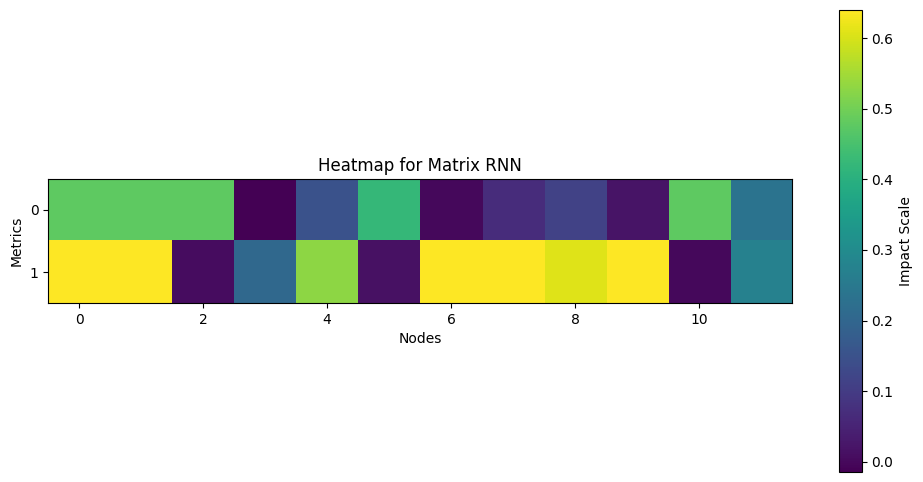

M2 [[0.03751632 0.01169829 0.01518043 0.01402313 0.01518043 0.01518043
  0.00670631 0.01518043 0.         0.00423729 0.01518043 0.01518043]
 [0.         0.41564256 0.11688846 0.32366133 0.11688846 0.11688846
  0.41564256 0.12397472 0.12397472 0.41564256 0.06936526 0.11688846]]


<Figure size 640x480 with 0 Axes>

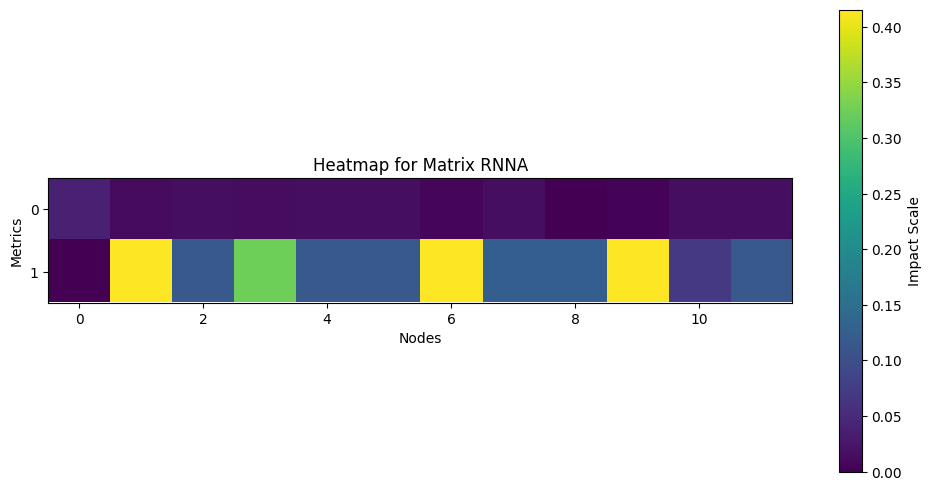

In [13]:
modelRNN=torch.load("./dataModel/model_RNN_min_30_max_35_rep_16.model")
modelRNNWithAttention=torch.load("./dataModel/model_RNNA_min_30_max_35_rep_16.model")
s,t = generateTrainData(100, [30,30])  
S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()
M1 = removalIntoMatrix(S,12,H)
print(f"M1 {M1}")
#imshow(M1)
plt.figure(figsize=(12, 6))
plt.imshow(M1)
plt.colorbar(label='Impact Scale')
plt.title('Heatmap for Matrix RNN')
plt.xlabel('Nodes')
plt.ylabel('Metrics')
plt.yticks([0, 1], ['0', '1'])  # Setting y-axis labels to 0 and 1
plt.show()

S,H=shrinkingDecompositionInformation(modelRNNWithAttention,12,s,t.transpose(),numbers = [0,1],whichTS=29,dsLength=30)
figure()

M2 = removalIntoMatrix(S,12,H)
print(f"M2 {M2}")
#imshow(M2)
plt.figure(figsize=(12, 6))
plt.imshow(M2)
plt.colorbar(label='Impact Scale')
plt.title('Heatmap for Matrix RNNA')
plt.xlabel('Nodes')
plt.ylabel('Metrics')
plt.yticks([0, 1], ['0', '1'])  # Setting y-axis labels to 0 and 1
plt.show()

In [14]:
def shannon_entropy(matrix):
    probabilities = matrix.flatten() 
    probabilities = probabilities[probabilities > 0]  # Remove zeros to avoid log(0)
    probabilities = probabilities / probabilities.sum()
    return -np.sum(probabilities * np.log2(probabilities))

In [16]:
def kmeans_thresholding(matrix):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=2, n_init=10).fit(flat_matrix.reshape(-1, 1))

    centroids = kmeans.cluster_centers_.flatten()
    # Determine threshold as the mean of centroids or the higher centroid
    threshold = centroids.mean() if len(centroids) > 1 else centroids[0]

    # Count the number of nodes exceeding the threshold
    count_exceeding = np.sum(flat_matrix > threshold)

    return threshold, count_exceeding

# Apply KMeans thresholding to M1 and M2
threshold_M1, count_exceeding_M1 = kmeans_thresholding(M1)
threshold_M2, count_exceeding_M2 = kmeans_thresholding(M2)

(threshold_M1, count_exceeding_M1, threshold_M2, count_exceeding_M2)

(0.32263403351474934, 12, 0.22007693906513057, 4)

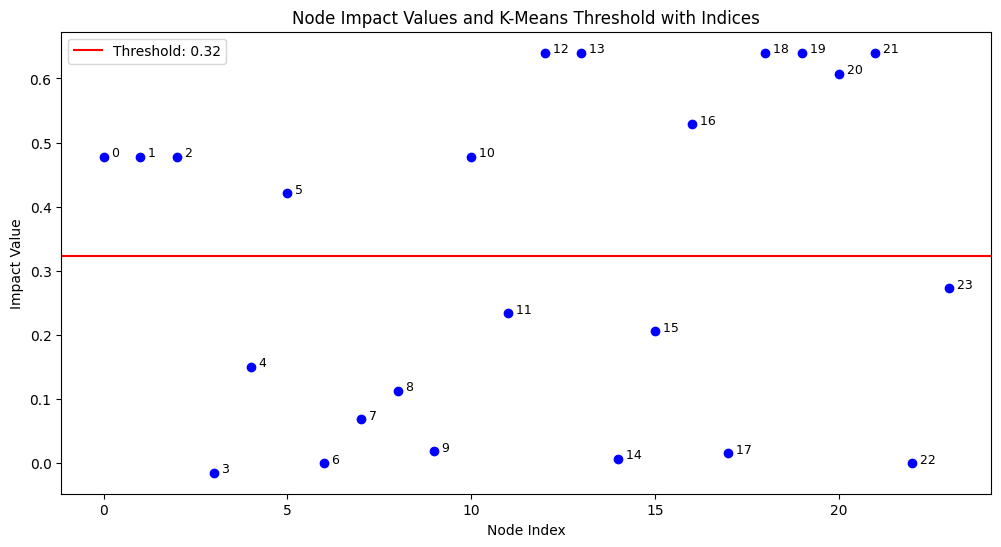

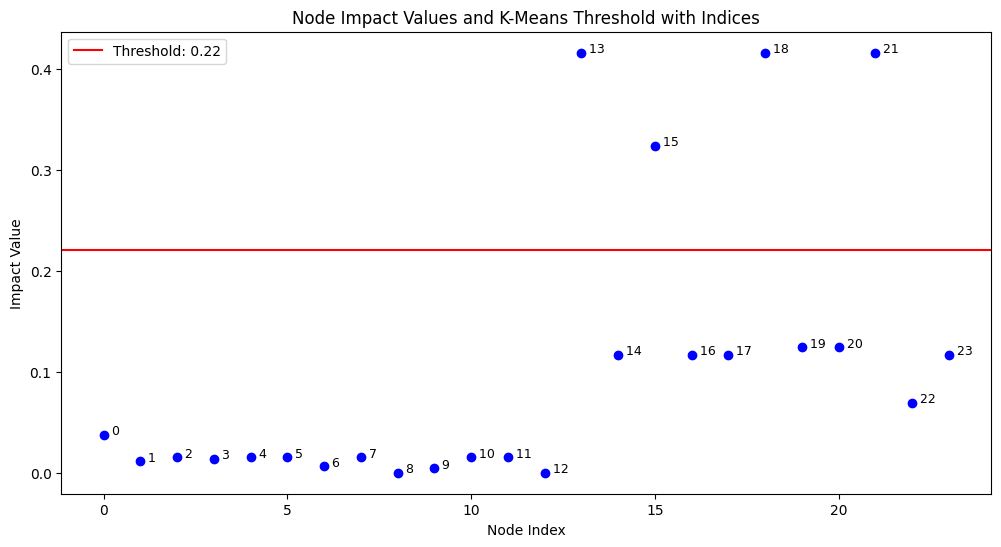

In [28]:
def plot_kmeans_thresholding_with_index(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Generate indices for each point in the flattened matrix
    indices = range(len(flat_matrix))

    # Plot the flattened matrix values and the threshold line
    plt.figure(figsize=(12, 6))
    for index, value in zip(indices, flat_matrix):
        plt.scatter(index, value, color='blue')
        #plt.text(index, value, str(index) + " " + str(value), fontsize=9)
        plt.text(index, value, "  " +str(index), fontsize=9)

    plt.axhline(y=threshold, color='red', linestyle='-', label=f'Threshold: {threshold:.2f}')
    plt.xlabel('Node Index')
    plt.ylabel('Impact Value')
    plt.title('Node Impact Values and K-Means Threshold with Indices')
    plt.legend()
    plt.show()

# Apply KMeans thresholding to M1 and M2
threshold_M1, count_exceeding_M1 = kmeans_thresholding(M1)
threshold_M2, count_exceeding_M2 = kmeans_thresholding(M2)

# Plotting for M1 and M2 with indices
plot_kmeans_thresholding_with_index(M1, threshold_M1)
plot_kmeans_thresholding_with_index(M2, threshold_M2)

In [17]:
def threshold_binarize_matrix(matrix, threshold):
    # Flatten the matrix
    flat_matrix = matrix.flatten()

    # Apply thresholding
    binarized_matrix = np.where(flat_matrix >= threshold, 1, 0)

    # Reshape to the original matrix shape
    binarized_matrix = binarized_matrix.reshape(matrix.shape)

    return binarized_matrix



In [18]:
def calculate_counts(matrix):
    transposed_matrix = matrix.T
    count_11, count_00, count_mixed = 0, 0, 0
    for row in transposed_matrix:
        if np.array_equal(row, [1, 1]):
            count_11 += 1
        elif np.array_equal(row, [0, 0]):
            count_00 += 1
        else:
            count_mixed += 1
    return count_11, count_00, count_mixed

In [31]:
from scipy.stats import entropy


# Constants
kinds = ["RNN", "RNNA"]  # Assuming you have these types
min_lengths = [30]  # Example lengths, adjust as needed
max_lengths = [35]  # Example lengths, adjust as needed
num_reps = 31  # Example repetitions, adjust as needed

# Placeholder for the results
results = []

# Gathering data
for min_len, max_len in zip(min_lengths, max_lengths):
    for kind in kinds:
        metrics_list = []

        for rep in range(num_reps):
            filename = f"./dataModel/model_{kind}_min_{min_len}_max_{max_len}_rep_{rep}.model"
            try:
                # Load the model
                model = torch.load(filename)
                s,t = generateTrainData(100, [min_len,min_len])  
                S,H=shrinkingDecompositionInformation(modelRNN,12,s,t.transpose(),numbers = [0,1],whichTS=min_len -1,dsLength=min_len)
                # Removal into matrix
                M = removalIntoMatrix(S, 12, H)

                # Calculate metrics
                sum_abs = np.sum(np.abs(M))
                mean = np.mean(M)
                std = np.std(M)
                entropy_s = shannon_entropy(M)
                max_val = np.max(M)
                min_val = np.min(M)
                threshold, count_exceeding = kmeans_thresholding(M)
                binarized_matrix = np.where(M.flatten() >= threshold, 1, 0).reshape(M.shape)
                count_11, count_00, count_mixed = calculate_counts(binarized_matrix)
                ratio_11_00_mixed = count_11 / (count_mixed + count_00) if (count_mixed + count_00) != 0 else 0
                ratio_11_mixed = count_11 / count_mixed if count_mixed != 0 else 0

                metrics = {
                    "Kind": kind,
                    "Min_Length": min_len,
                    "Max_Length": max_len,
                    "Repetition": rep,
                    "Sum of Absolute Values": sum_abs,
                    "Mean Value": mean,
                    "Standard Deviation": std,
                    "Maximum Value": max_val,
                    "Minimum Value": min_val,
                    "Shannon Entropy": entropy_s,
                    "Kmeans Threshold": threshold,
                    "Kmeans Nodes Exceeding": count_exceeding,
                    "Overlap with zeroes": ratio_11_00_mixed,
                    "Overlap no zeroes": ratio_11_mixed
                }

                # Append this dictionary to the results list
                results.append(metrics)

            except FileNotFoundError:
                print(f"File not found: {filename}")
                continue

# Create a DataFrame from the results list
df = pd.DataFrame(results)
df

,Kind,Min_Length,Max_Length,Repetition,Sum of Absolute Values,Mean Value,Standard Deviation,Maximum Value,Minimum Value,Shannon Entropy,Kmeans Threshold,Kmeans Nodes Exceeding,Overlap with zeroes,Overlap no zeroes
0,RNN,30,35,0,8.408940,0.350373,0.237919,0.629743,0.000000,4.136636,0.313128,14,0.714286,1.250000
1,RNN,30,35,1,8.046364,0.335134,0.233316,0.622598,-0.001225,4.102055,0.317172,13,0.333333,0.428571
2,RNN,30,35,2,8.287653,0.342354,0.220959,0.614072,-0.019005,4.175754,0.290338,15,0.714286,1.000000
3,RNN,30,35,3,7.284598,0.303525,0.228042,0.581036,0.000000,4.057929,0.303525,12,0.200000,0.250000
4,RNN,30,35,4,8.075974,0.336499,0.240022,0.622688,0.000000,4.083340,0.336499,12,0.200000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,RNNA,30,35,26,8.167053,0.340294,0.239625,0.643991,0.000000,4.098164,0.322270,13,0.333333,0.428571
58,RNNA,30,35,27,8.882934,0.369447,0.258974,0.744299,-0.008106,4.116893,0.350185,13,0.333333,0.428571
59,RNNA,30,35,28,7.597188,0.316340,0.220828,0.575989,-0.002512,4.086289,0.282023,14,0.500000,0.666667
60,RNNA,30,35,29,7.522505,0.313330,0.230180,0.614480,-0.001290,4.064964,0.313330,12,0.200000,0.250000
